# **Course-Recommendation-System**
## *By*
## **Manoj Kumar Bag** & **Amborish Sen**





## Recommendation System
A recommendation system is a system that seeks to predict or filter preferences according to the user's choices. The created Web-App using Python is a similar system, which suggests courses based on the user's liked or searched courses.

## System Overview
*  In this course recommendation system, content-based similarity filtering based on the course tags which the users either watch or search is being used.
* The dataset used is of the Coursera Courses Dataset which contains over 10,000 data!

## 1. Importing Dependencies

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error


print('Dependencies Imported')

Dependencies Imported


## 2. Data Loading and Preprocessing

In [ ]:
# Load the datasets
data = pd.read_csv("personalized_learning_dataset.csv")
data.head(5)

,Student_ID,Age,Gender,Education_Level,Course_Name,Time_Spent_on_Videos,Quiz_Attempts,Quiz_Scores,Forum_Participation,Assignment_Completion_Rate,Engagement_Level,Final_Exam_Score,Learning_Style,Feedback_Score,Dropout_Likelihood
0,S00001,15,Female,High School,Machine Learning,171,4,67,2,89,Medium,51,Visual,1,No
1,S00002,49,Male,Undergraduate,Python Basics,156,4,64,0,94,Medium,92,Reading/Writing,5,No
2,S00003,20,Female,Undergraduate,Python Basics,217,2,55,2,67,Medium,45,Reading/Writing,1,No
3,S00004,37,Female,Undergraduate,Data Science,489,1,65,43,60,High,59,Visual,4,No
4,S00005,34,Female,Postgraduate,Python Basics,496,3,59,34,88,Medium,93,Visual,3,No


In [ ]:
# Make two catagory
students_df = data
courses_df = data # Assuming the same dataset is used for courses


In [ ]:
# Display basic information about datasets
print("Students Dataset Shape:", students_df.shape)
print("Courses Dataset Shape:", courses_df.shape)


Students Dataset Shape: (10000, 15)
Courses Dataset Shape: (10000, 15)


In [ ]:
# Check for missing values
print("\nMissing values in courses dataset:")
print(courses_df.isnull().sum())
print("\nMissing values in students dataset:")
print(students_df.isnull().sum())


Missing values in courses dataset:
Student_ID                    0
Age                           0
Gender                        0
Education_Level               0
Course_Name                   0
Time_Spent_on_Videos          0
Quiz_Attempts                 0
Quiz_Scores                   0
Forum_Participation           0
Assignment_Completion_Rate    0
Engagement_Level              0
Final_Exam_Score              0
Learning_Style                0
Feedback_Score                0
Dropout_Likelihood            0
dtype: int64

Missing values in students dataset:
Student_ID                    0
Age                           0
Gender                        0
Education_Level               0
Course_Name                   0
Time_Spent_on_Videos          0
Quiz_Attempts                 0
Quiz_Scores                   0
Forum_Participation           0
Assignment_Completion_Rate    0
Engagement_Level              0
Final_Exam_Score              0
Learning_Style                0
Feedback_Score    

In [ ]:
# Data preprocessing for courses
def preprocess_courses_data(df):
    """Preprocess the courses dataset"""
    df_clean = df.copy()

    # Handle missing values
    df_clean = df_clean.dropna()

    # Clean course names
    df_clean['Course_Name'] = df_clean['Course_Name'].str.replace(',', ' ')

    # Create tags combining course name, description, and skills
    # Ensure these columns exist before attempting to access them
    required_cols = ['Course Name', 'Difficulty Level', 'Engagement_Level', 'Learning_Style']
    for col in required_cols:
        if col not in df_clean.columns:
             df_clean[col] = '' # Add empty column if missing


    df_clean['tags'] = (df_clean['Course Name'] + ' ' +
                       df_clean['Difficulty Level'] + ' ' +
                       df_clean['Engagement_Level'] + ' ' +
                       df_clean['Learning_Style']).str.lower()


    # Extract numeric course rating - using Feedback_Score as a proxy for rating
    df_clean['Course_Rating_Numeric'] = pd.to_numeric(df_clean['Feedback_Score'], errors='coerce')


    return df_clean

# Data preprocessing for students
def preprocess_students_data(df):
    """Preprocess the students dataset"""
    df_clean = df.copy()

    # Convert categorical variables to numeric
    df_clean['Gender_encoded'] = df_clean['Gender'].map({'Male': 1, 'Female': 0, 'Other': 2})
    df_clean['Education_encoded'] = df_clean['Education_Level'].map({
        'High School': 0, 'Undergraduate': 1, 'Postgraduate': 2
    })
    df_clean['Learning_Style_encoded'] = df_clean['Learning_Style'].map({
        'Visual': 0, 'Auditory': 1, 'Kinesthetic': 2, 'Reading/Writing': 3
    })
    df_clean['Dropout_encoded'] = df_clean['Dropout_Likelihood'].map({'Yes': 1, 'No': 0})

    return df_clean


students_clean = preprocess_students_data(students_df)
courses_clean = preprocess_courses_data(courses_df)


print("Data preprocessing completed!")

Data preprocessing completed!


## 3. Content-Based Filtering

In [ ]:
class ContentBasedRecommender:
    def __init__(self):
        self.tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
        self.cosine_sim = None
        self.courses_df = None

    def fit(self, courses_df):
        """Fit the content-based recommender"""
        self.courses_df = courses_df.reset_index(drop=True)

        # Create TF-IDF matrix
        tfidf_matrix = self.tfidf.fit_transform(self.courses_df['tags'])

        # Calculate cosine similarity
        self.cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

        print(f"Content-based model fitted with {len(self.courses_df)} courses")

    def recommend(self, course_name, n_recommendations=5):
        """Recommend courses based on content similarity"""
        try:
            # Find the index of the course
            idx = self.courses_df[self.courses_df['Course_Name'] == course_name].index[0]

            # Get similarity scores
            sim_scores = list(enumerate(self.cosine_sim[idx]))

            # Sort courses based on similarity scores
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

            # Get top N similar courses (excluding the input course)
            course_indices = [i[0] for i in sim_scores[1:n_recommendations+1]]

            # Return recommended courses
            recommendations = self.courses_df.iloc[course_indices][['Course_Name', 'Course_Rating_Numeric']]
            return recommendations

        except IndexError:
            print(f"Course '{course_name}' not found in the dataset")
            return pd.DataFrame()

## 4. Collaborative Filtering

In [ ]:
class CollaborativeFilteringRecommender:
    def __init__(self):
        self.user_item_matrix = None
        self.user_similarity = None
        self.students_df = None

    def create_user_item_matrix(self, students_df):
        """Create user-item interaction matrix"""
        # Use Final_Exam_Score as the rating/interaction measure
        pivot_table = students_df.pivot_table(
            index='Student_ID',
            columns='Course_Name',
            values='Final_Exam_Score',
            fill_value=0
        )
        return pivot_table

    def fit(self, students_df):
        """Fit the collaborative filtering model"""
        self.students_df = students_df
        self.user_item_matrix = self.create_user_item_matrix(students_df)

        # Calculate and display sparsity
        num_users = self.user_item_matrix.shape[0]
        num_courses = self.user_item_matrix.shape[1]
        num_interactions = (self.user_item_matrix != 0).sum().sum()
        total_possible_interactions = num_users * num_courses
        sparsity = (1 - num_interactions / total_possible_interactions) * 100
        print(f"User-item matrix shape: {self.user_item_matrix.shape}")
        print(f"Number of interactions: {num_interactions}")
        print(f"Total possible interactions: {total_possible_interactions}")
        print(f"Sparsity of user-item matrix: {sparsity:.2f}%")


        # Calculate user similarity based on course performance
        self.user_similarity = cosine_similarity(self.user_item_matrix.fillna(0))

        print(f"Collaborative filtering model fitted with {len(self.user_item_matrix)} users")

    def recommend_for_user(self, student_id, n_recommendations=5):
        """Recommend courses for a specific user"""
        try:
            if student_id not in self.user_item_matrix.index:
                print(f"Student {student_id} not found")
                return pd.DataFrame()

            # Get user index
            user_idx = list(self.user_item_matrix.index).index(student_id)

            # Get similar users
            user_sim_scores = list(enumerate(self.user_similarity[user_idx]))
            user_sim_scores = sorted(user_sim_scores, key=lambda x: x[1], reverse=True)

            # Get top similar users (excluding self)
            similar_users = [i for i in user_sim_scores[1:11]]  # Top 10 similar users
            print(f"Similar users for {student_id}: {[self.user_item_matrix.index[i[0]] for i in similar_users]}")


            # Get courses that similar users liked but current user hasn't taken
            user_courses = set(self.user_item_matrix.loc[student_id][self.user_item_matrix.loc[student_id] > 0].index)
            print(f"Courses taken by {student_id}: {user_courses}")

            recommendations = {}
            for sim_user_idx, sim_score in similar_users:
                sim_user_id = self.user_item_matrix.index[sim_user_idx]
                sim_user_courses = self.user_item_matrix.loc[sim_user_id]

                for course in sim_user_courses[sim_user_courses > 0].index:
                    if course not in user_courses:
                        if course not in recommendations:
                            recommendations[course] = []
                        recommendations[course].append(sim_user_courses[course])

            print(f"Raw recommendations from similar users: {recommendations}")

            # Calculate average ratings for recommended courses
            course_recommendations = []
            for course, scores in recommendations.items():
                avg_score = np.mean(scores)
                course_recommendations.append((course, avg_score))

            # Sort by average score
            course_recommendations = sorted(course_recommendations, key=lambda x: x[1], reverse=True)

            # Return top N recommendations
            top_recommendations = course_recommendations[:n_recommendations]
            return pd.DataFrame(top_recommendations, columns=['Course', 'Predicted_Score'])

        except Exception as e:
            print(f"Error in recommendation: {e}")
            return pd.DataFrame()

## 5. Hybrid Recommendation System

In [ ]:
class HybridRecommender:
    def __init__(self, content_weight=0.6, collaborative_weight=0.4):
        self.content_recommender = ContentBasedRecommender()
        self.collaborative_recommender = CollaborativeFilteringRecommender()
        self.content_weight = content_weight
        self.collaborative_weight = collaborative_weight

    def fit(self, courses_df, students_df):
        """Fit both recommenders"""
        self.content_recommender.fit(courses_df)
        self.collaborative_recommender.fit(students_df)

    def recommend(self, student_id=None, course_name=None, n_recommendations=5):
        """Hybrid recommendation combining both approaches"""
        content_recs = pd.DataFrame()
        collab_recs = pd.DataFrame()

        # Get content-based recommendations
        if course_name:
            content_recs = self.content_recommender.recommend(course_name, n_recommendations)

        # Get collaborative filtering recommendations
        if student_id:
            collab_recs = self.collaborative_recommender.recommend_for_user(student_id, n_recommendations)

        # Combine recommendations
        if not content_recs.empty and not collab_recs.empty:
            # Normalize scores
            if 'Course_Rating_Numeric' in content_recs.columns:
                content_recs['normalized_score'] = content_recs['Course_Rating_Numeric'] / content_recs['Course_Rating_Numeric'].max()

            if 'Predicted_Score' in collab_recs.columns:
                collab_recs['normalized_score'] = collab_recs['Predicted_Score'] / collab_recs['Predicted_Score'].max()

            # Merge and calculate hybrid scores
            hybrid_scores = {}

            # Add content-based scores
            for _, row in content_recs.iterrows():
                course = row['Course_Name']
                score = row.get('normalized_score', 0) * self.content_weight
                hybrid_scores[course] = score

            # Add collaborative scores
            for _, row in collab_recs.iterrows():
                course = row['Course']
                score = row.get('normalized_score', 0) * self.collaborative_weight
                if course in hybrid_scores:
                    hybrid_scores[course] += score
                else:
                    hybrid_scores[course] = score

            # Sort by hybrid score
            sorted_recommendations = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)
            return pd.DataFrame(sorted_recommendations[:n_recommendations],
                              columns=['Course', 'Hybrid_Score'])

        elif not content_recs.empty:
            return content_recs
        elif not collab_recs.empty:
            return collab_recs
        else:
            return pd.DataFrame()

## 6. Evaluation Metrics

In [ ]:
def evaluate_recommendations(actual_ratings, predicted_ratings):
    """Evaluate recommendation quality"""
    if len(actual_ratings) == 0 or len(predicted_ratings) == 0:
        return None

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))

    # Calculate MAE
    mae = mean_absolute_error(actual_ratings, predicted_ratings)

    return {'RMSE': rmse, 'MAE': mae}

def calculate_precision_at_k(recommended_courses, relevant_courses, k):
    """Calculate Precision@K"""
    if k == 0:
        return 0

    recommended_k = set(recommended_courses[:k])
    relevant_set = set(relevant_courses)

    intersection = recommended_k.intersection(relevant_set)
    precision = len(intersection) / k

    return precision

def calculate_recall_at_k(recommended_courses, relevant_courses, k):
    """Calculate Recall@K"""
    if len(relevant_courses) == 0:
        return 0

    recommended_k = set(recommended_courses[:k])
    relevant_set = set(relevant_courses)

    intersection = recommended_k.intersection(relevant_set)
    recall = len(intersection) / len(relevant_set)

    return recall


## 7. Visualization Functions

In [ ]:
def plot_course_distribution():
    """Plot distribution of courses by difficulty and rating"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Course difficulty distribution
    difficulty_counts = courses_clean['Engagement_Level'].value_counts()
    axes[0, 0].pie(difficulty_counts.values, labels=difficulty_counts.index, autopct='%1.1f%%')
    axes[0, 0].set_title('Course Distribution by Engagement Level')

    # Course rating distribution
    axes[0, 1].hist(courses_clean['Course_Rating_Numeric'].dropna(), bins=20, alpha=0.7)
    axes[0, 1].set_title('Course Rating Distribution')
    axes[0, 1].set_xlabel('Rating')
    axes[0, 1].set_ylabel('Frequency')

    # Course difficulty vs rating
    axes[1, 0].scatter(courses_clean['Engagement_Level'], courses_clean['Course_Rating_Numeric'], alpha=0.6)
    axes[1, 0].set_title('Course Difficulty vs Rating')
    fig.delaxes(axes[1, 0])

    # Average rating by difficulty level
    avg_rating_by_difficulty = courses_clean.groupby('Engagement_Level')['Course_Rating_Numeric'].mean()
    axes[1, 1].bar(avg_rating_by_difficulty.index, avg_rating_by_difficulty.values)
    axes[1, 1].set_title('Average Rating by Engagement Level')
    axes[1, 1].set_xlabel('Engagement Level')
    axes[1, 1].set_ylabel('Average Rating')

    plt.tight_layout()
    plt.show()

def plot_student_analysis():
    """Plot student learning analytics"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Age distribution
    axes[0, 0].hist(students_clean['Age'], bins=20, alpha=0.7)
    axes[0, 0].set_title('Student Age Distribution')
    axes[0, 0].set_xlabel('Age')
    axes[0, 0].set_ylabel('Frequency')

    # Gender distribution
    gender_counts = students_clean['Gender'].value_counts()
    axes[0, 1].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%')
    axes[0, 1].set_title('Gender Distribution')

    # Education level distribution
    education_counts = students_clean['Education_Level'].value_counts()
    axes[0, 2].bar(education_counts.index, education_counts.values)
    axes[0, 2].set_title('Education Level Distribution')
    axes[0, 2].tick_params(axis='x', rotation=45)

    # Learning style distribution
    learning_style_counts = students_clean['Learning_Style'].value_counts()
    axes[1, 0].bar(learning_style_counts.index, learning_style_counts.values)
    axes[1, 0].set_title('Learning Style Distribution')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Course performance vs engagement
    axes[1, 1].scatter(students_clean['Final_Exam_Score'], students_clean['Quiz_Scores'], alpha=0.6)
    axes[1, 1].set_title('Final Exam Score vs Quiz Scores')
    axes[1, 1].set_xlabel('Final Exam Score')
    axes[1, 1].set_ylabel('Quiz Scores')

    # Dropout likelihood by course
    dropout_by_course = students_clean.groupby('Course_Name')['Dropout_encoded'].mean()
    top_dropout_courses = dropout_by_course.nlargest(10)
    axes[1, 2].barh(range(len(top_dropout_courses)), top_dropout_courses.values)
    axes[1, 2].set_yticks(range(len(top_dropout_courses)))
    axes[1, 2].set_yticklabels(top_dropout_courses.index, fontsize=8)
    axes[1, 2].set_title('Top 10 Courses by Dropout Rate')
    axes[1, 2].set_xlabel('Dropout Rate')

    plt.tight_layout()
    plt.show()

## 8. Main Execution and Testing

=== Course Recommendation System ===

1. Plotting course distribution...


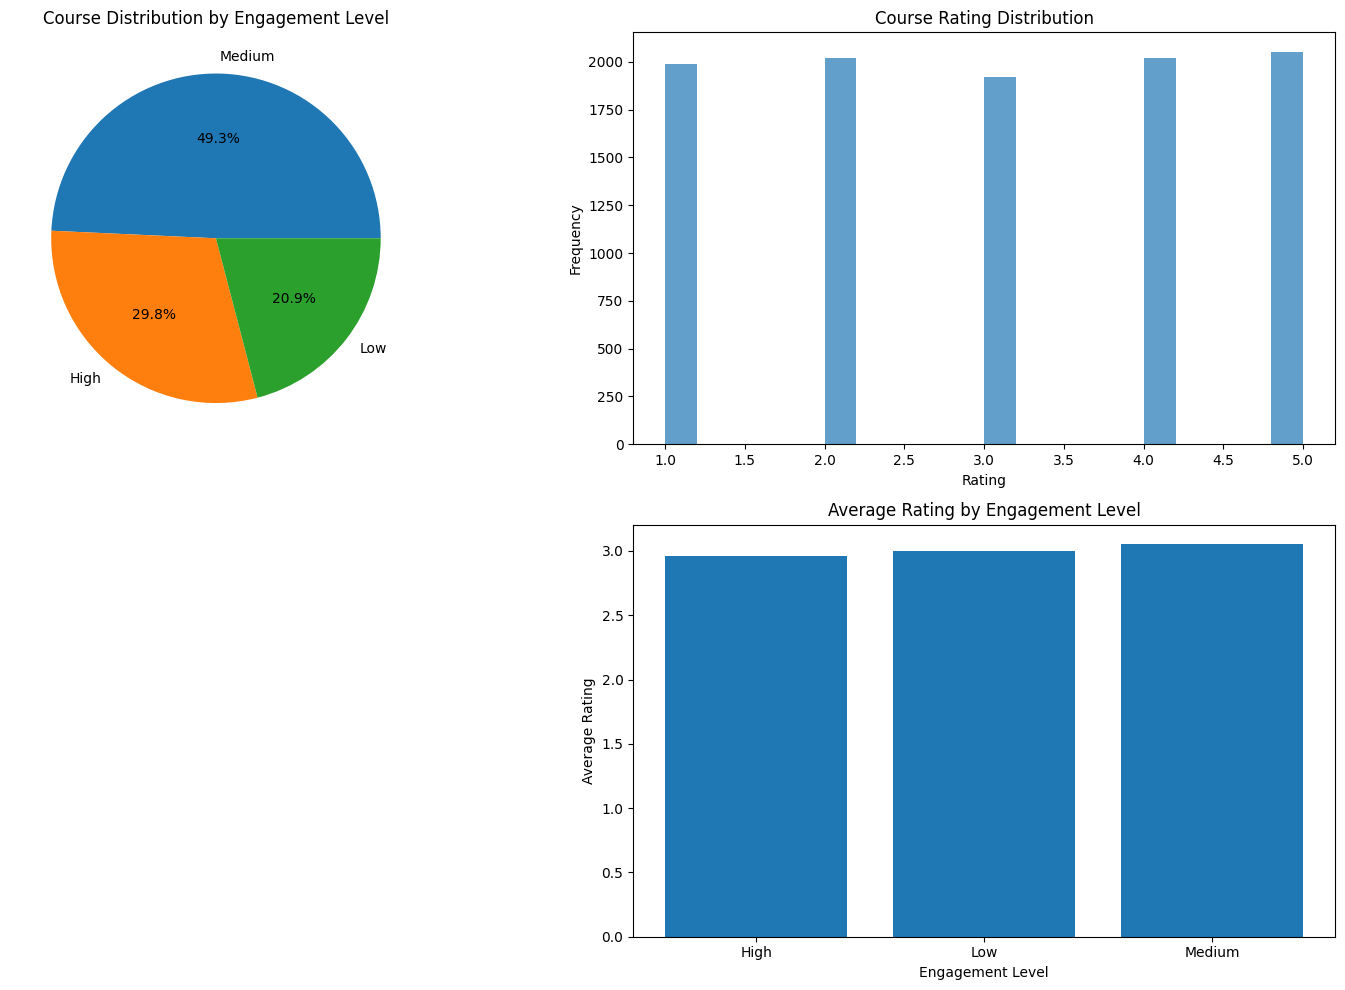


2. Plotting student analysis...


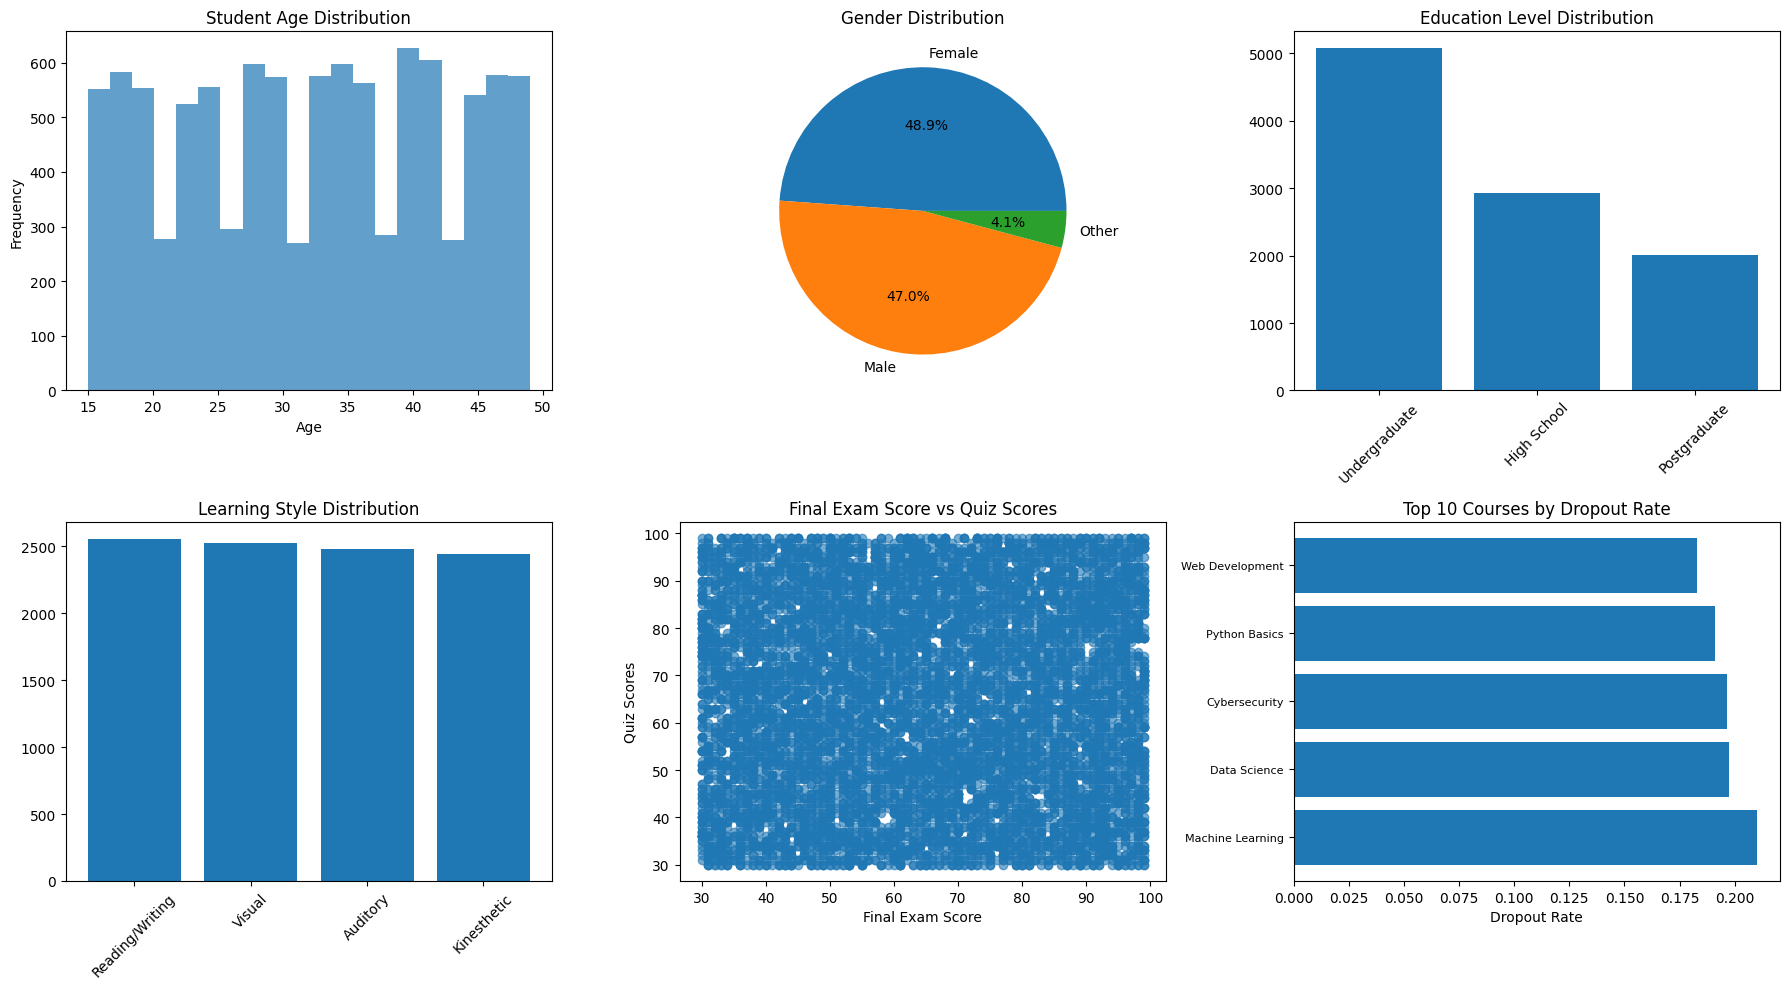


3. Initializing Hybrid Recommender...
Content-based model fitted with 10000 courses
User-item matrix shape: (10000, 5)
Number of interactions: 10000
Total possible interactions: 50000
Sparsity of user-item matrix: 80.00%
Collaborative filtering model fitted with 10000 users

4. Testing Content-Based Recommendations:
Recommendations for course: Machine Learning
         Course_Name  Course_Rating_Numeric
4      Python Basics                      3
5    Web Development                      4
20  Machine Learning                      4
22     Cybersecurity                      3
23      Data Science                      4

5. Testing Collaborative Filtering:
Recommendations for student: S00001
Similar users for S00001: ['S00014', 'S00017', 'S00018', 'S00021', 'S00031', 'S00040', 'S00047', 'S00052', 'S00056', 'S00064']
Courses taken by S00001: {'Machine Learning'}
Raw recommendations from similar users: {}
Empty DataFrame
Columns: [Course, Predicted_Score]
Index: []

6. Testing Hybrid Rec

In [ ]:
def main():
    """Main function to demonstrate the recommendation system"""
    print("=== Course Recommendation System ===\n")

    # Plot data distributions
    print("1. Plotting course distribution...")
    plot_course_distribution()

    print("\n2. Plotting student analysis...")
    plot_student_analysis()

    # Initialize hybrid recommender
    print("\n3. Initializing Hybrid Recommender...")
    hybrid_rec = HybridRecommender()
    hybrid_rec.fit(courses_clean, students_clean)

    # Test content-based recommendations
    print("\n4. Testing Content-Based Recommendations:")
    # Select a sample course name for testing
    sample_course = courses_clean['Course_Name'].iloc[0]
    print(f"Recommendations for course: {sample_course}")
    content_recs = hybrid_rec.content_recommender.recommend(sample_course, 5)
    print(content_recs)

    # Test collaborative filtering
    print("\n5. Testing Collaborative Filtering:")
    # Select a sample student ID for testing
    sample_student = students_clean['Student_ID'].iloc[0]
    print(f"Recommendations for student: {sample_student}")
    collab_recs = hybrid_rec.collaborative_recommender.recommend_for_user(sample_student, 5)
    print(collab_recs)

    # Test hybrid recommendations
    print("\n6. Testing Hybrid Recommendations:")
    hybrid_recs = hybrid_rec.recommend(student_id=sample_student, course_name=sample_course, n_recommendations=5)
    print(hybrid_recs)

    # Performance evaluation
    print("\n7. Evaluating System Performance...")

    # Sample evaluation
    sample_students = students_clean['Student_ID'].sample(10).tolist()

    precision_scores = []
    recall_scores = []

    for student in sample_students:
        # Get student's actual courses
        student_courses = students_clean[students_clean['Student_ID'] == student]['Course_Name'].tolist()

        # Get recommendations
        recommendations = hybrid_rec.collaborative_recommender.recommend_for_user(student, 5)

        if not recommendations.empty:
            recommended_courses = recommendations['Course'].tolist()

            # Calculate precision and recall
            precision = calculate_precision_at_k(recommended_courses, student_courses, 5)
            recall = calculate_recall_at_k(recommended_courses, student_courses, 5)

            precision_scores.append(precision)
            recall_scores.append(recall)

    if precision_scores and recall_scores:
        avg_precision = np.mean(precision_scores)
        avg_recall = np.mean(recall_scores)

        print(f"Average Precision@5: {avg_precision:.4f}")
        print(f"Average Recall@5: {avg_recall:.4f}")

    print("\n=== Recommendation System Demo Complete ===")

# Run the main function
if __name__ == "__main__":
    main()

## 9. Interactive Recommendation Function

In [ ]:
def get_personalized_recommendations(student_id, course_name=None, n_recommendations=5):
    """
    Get personalized recommendations for a student

    Parameters:
    - student_id: ID of the student
    - course_name: Optional course name for content-based filtering
    - n_recommendations: Number of recommendations to return

    Returns:
    - DataFrame with recommendations
    """
    # Initialize recommender
    hybrid_rec = HybridRecommender()
    hybrid_rec.fit(courses_clean, students_clean)

    # Get student information
    student_info = students_clean[students_clean['Student_ID'] == student_id]

    if student_info.empty:
        print(f"Student {student_id} not found!")
        return pd.DataFrame()

    print(f"\nStudent Profile:")
    print(f"Age: {student_info.iloc[0]['Age']}")
    print(f"Gender: {student_info.iloc[0]['Gender']}")
    print(f"Education Level: {student_info.iloc[0]['Education_Level']}")
    print(f"Learning Style: {student_info.iloc[0]['Learning_Style']}")
    print(f"Current Course: {student_info.iloc[0]['Course_Name']}")

    # Get recommendations
    recommendations = hybrid_rec.recommend(
        student_id=student_id,
        course_name=course_name,
        n_recommendations=n_recommendations
    )

    print(f"\nTop {n_recommendations} Recommendations:")
    print(recommendations)

    return recommendations



In [ ]:
# Step 1: show for Machine Learning
sample_student_id = students_clean['Student_ID'].iloc[4]
recommendations_data_science = get_personalized_recommendations(sample_student_id, course_name='Machine Learning')
display(recommendations_data_science)

Content-based model fitted with 10000 courses
User-item matrix shape: (10000, 5)
Number of interactions: 10000
Total possible interactions: 50000
Sparsity of user-item matrix: 80.00%
Collaborative filtering model fitted with 10000 users

Student Profile:
Age: 34
Gender: Female
Education Level: Postgraduate
Learning Style: Visual
Current Course: Python Basics
Similar users for S00005: ['S00003', 'S00005', 'S00012', 'S00013', 'S00016', 'S00027', 'S00036', 'S00037', 'S00038', 'S00053']
Courses taken by S00005: {'Python Basics'}
Raw recommendations from similar users: {}

Top 5 Recommendations:
         Course_Name  Course_Rating_Numeric
4      Python Basics                      3
5    Web Development                      4
20  Machine Learning                      4
22     Cybersecurity                      3
23      Data Science                      4


,Course_Name,Course_Rating_Numeric
4,Python Basics,3
5,Web Development,4
20,Machine Learning,4
22,Cybersecurity,3
23,Data Science,4


In [ ]:
# Step 2: Try a different course name ('Data Science')
sample_student_id = students_clean['Student_ID'].iloc[0]
recommendations_data_science = get_personalized_recommendations(sample_student_id, course_name='Data Science')
display(recommendations_data_science)

Content-based model fitted with 10000 courses
User-item matrix shape: (10000, 5)
Number of interactions: 10000
Total possible interactions: 50000
Sparsity of user-item matrix: 80.00%
Collaborative filtering model fitted with 10000 users

Student Profile:
Age: 15
Gender: Female
Education Level: High School
Learning Style: Visual
Current Course: Machine Learning
Similar users for S00001: ['S00014', 'S00017', 'S00018', 'S00021', 'S00031', 'S00040', 'S00047', 'S00052', 'S00056', 'S00064']
Courses taken by S00001: {'Machine Learning'}
Raw recommendations from similar users: {}

Top 5 Recommendations:
          Course_Name  Course_Rating_Numeric
10       Data Science                      3
33       Data Science                      5
54       Data Science                      1
63   Machine Learning                      4
101     Python Basics                      4


,Course_Name,Course_Rating_Numeric
10,Data Science,3
33,Data Science,5
54,Data Science,1
63,Machine Learning,4
101,Python Basics,4


In [ ]:
# Step 3: Attempt collaborative filtering with a different student
sample_student_id = students_clean['Student_ID'].iloc[2]
recommendations_another_student = get_personalized_recommendations(sample_student_id, course_name='Python Basics')
display(recommendations_another_student)

Content-based model fitted with 10000 courses
User-item matrix shape: (10000, 5)
Number of interactions: 10000
Total possible interactions: 50000
Sparsity of user-item matrix: 80.00%
Collaborative filtering model fitted with 10000 users

Student Profile:
Age: 20
Gender: Female
Education Level: Undergraduate
Learning Style: Reading/Writing
Current Course: Python Basics
Similar users for S00003: ['S00003', 'S00005', 'S00012', 'S00013', 'S00016', 'S00027', 'S00036', 'S00037', 'S00038', 'S00053']
Courses taken by S00003: {'Python Basics'}
Raw recommendations from similar users: {}

Top 5 Recommendations:
        Course_Name  Course_Rating_Numeric
2     Python Basics                      1
8     Cybersecurity                      2
43  Web Development                      1
65    Cybersecurity                      4
70  Web Development                      4


,Course_Name,Course_Rating_Numeric
2,Python Basics,1
8,Cybersecurity,2
43,Web Development,1
65,Cybersecurity,4
70,Web Development,4


In [ ]:
# Performance evaluation (extracted from main function)
print("\n7. Evaluating System Performance...")

# Initialize recommenders (need to re-initialize as this is a new cell)
hybrid_rec = HybridRecommender()
hybrid_rec.fit(courses_clean, students_clean)


# Sample evaluation (you can expand this based on your needs)
sample_students = students_clean['Student_ID'].sample(10).tolist()

precision_scores = []
recall_scores = []

for student in sample_students:
    # Get student's actual courses
    student_courses = students_clean[students_clean['Student_ID'] == student]['Course_Name'].tolist()

    # Get recommendations
    recommendations = hybrid_rec.collaborative_recommender.recommend_for_user(student, 5)

    if not recommendations.empty:
        recommended_courses = recommendations['Course'].tolist()

        # Calculate precision and recall
        precision = calculate_precision_at_k(recommended_courses, student_courses, 5)
        recall = calculate_recall_at_k(recommended_courses, student_courses, 5)

        precision_scores.append(precision)
        recall_scores.append(recall)

if precision_scores and recall_scores:
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)

    print(f"Average Precision@5: {avg_precision:.4f}")
    print(f"Average Recall@5: {avg_recall:.4f}")
else:
    print("No recommendations were generated for the sample students, so precision and recall could not be calculated.")


7. Evaluating System Performance...
Content-based model fitted with 10000 courses
User-item matrix shape: (10000, 5)
Number of interactions: 10000
Total possible interactions: 50000
Sparsity of user-item matrix: 80.00%
Collaborative filtering model fitted with 10000 users
Similar users for S05736: ['S00010', 'S00011', 'S00015', 'S00024', 'S00026', 'S00033', 'S00034', 'S00043', 'S00050', 'S00055']
Courses taken by S05736: {'Data Science'}
Raw recommendations from similar users: {}
Similar users for S04703: ['S00014', 'S00017', 'S00018', 'S00021', 'S00031', 'S00040', 'S00047', 'S00052', 'S00056', 'S00064']
Courses taken by S04703: {'Machine Learning'}
Raw recommendations from similar users: {}
Similar users for S06782: ['S00010', 'S00011', 'S00015', 'S00024', 'S00026', 'S00033', 'S00034', 'S00043', 'S00050', 'S00055']
Courses taken by S06782: {'Data Science'}
Raw recommendations from similar users: {}
Similar users for S00552: ['S00010', 'S00011', 'S00015', 'S00024', 'S00026', 'S00033',

## 10. Save and Load Models

In [ ]:
import pickle

def save_model(model, filename):
    """Save trained model to file"""
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model saved to {filename}")

def load_model(filename):
    """Load trained model from file"""
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    print(f"Model loaded from {filename}")
    return model

# Example usage:
hybrid_rec = HybridRecommender()
hybrid_rec.fit(courses_clean, students_clean)
save_model(hybrid_rec, 'hybrid_recommender.pkl')

# To load later:
loaded_model = load_model('hybrid_recommender.pkl')


Content-based model fitted with 10000 courses
User-item matrix shape: (10000, 5)
Number of interactions: 10000
Total possible interactions: 50000
Sparsity of user-item matrix: 80.00%
Collaborative filtering model fitted with 10000 users
Model saved to hybrid_recommender.pkl
Model loaded from hybrid_recommender.pkl
